In [1]:

import numpy as np
import matplotlib.pyplot as plt
import PIL.Image
import argparse
from nanosam.mobile_sam.automatic_mask_generator import SamAutomaticMaskGenerator
import cv2

from nanosam.utils.predictor import Predictor as NanoPredictor


/usr/local/lib/python3.8/dist-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
/opt/nanosam/nanosam/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with nanosam.mobile_sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/opt/nanosam/nanosam/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_11m_224 in registry with nanosam.mobile_sam.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/opt/nanosam/nanosam/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_21m_224 in registry with nanosam.mobile

In [27]:
class NanoSamAutomaticMaskGenerator(SamAutomaticMaskGenerator):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.predictor = NanoPredictor(
                image_encoder_engine="/opt/nanosam/data/resnet18_image_encoder.engine",
                mask_decoder_engine="/opt/nanosam/data/mobile_sam_mask_decoder.engine"
            )

In [171]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)
    
def show_mask(mask,image):
    image=image.copy()


    image[mask] = [0, 0, 0]

    plt.imshow(image)


In [150]:
image = cv2.imread('/root/catkin_ws/src/guide_dog/src/log/20240830_112230/raw_image/image_0/image.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [151]:
import sys
sys.path.append("..")
from nanosam.mobile_sam.automatic_mask_generator import SamAutomaticMaskGenerator
from nanosam.mobile_sam.build_sam import sam_model_registry
#from nanosam.mobile_sam.predictor import SamPredictor
import torch
sam_checkpoint = "/root/catkin_ws/src/guide_dog/src/model/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
sam.eval()

mask_generator = SamAutomaticMaskGenerator(sam,points_per_side=20,points_per_batch=256,stability_score_thresh=0.1,min_mask_region_area=50)


Using device: cuda


In [173]:
masks = mask_generator.generate(image)
print(type(masks[0]))

<class 'dict'>


In [174]:
for mask in masks:
    show_mask(mask['segmentation'],image)

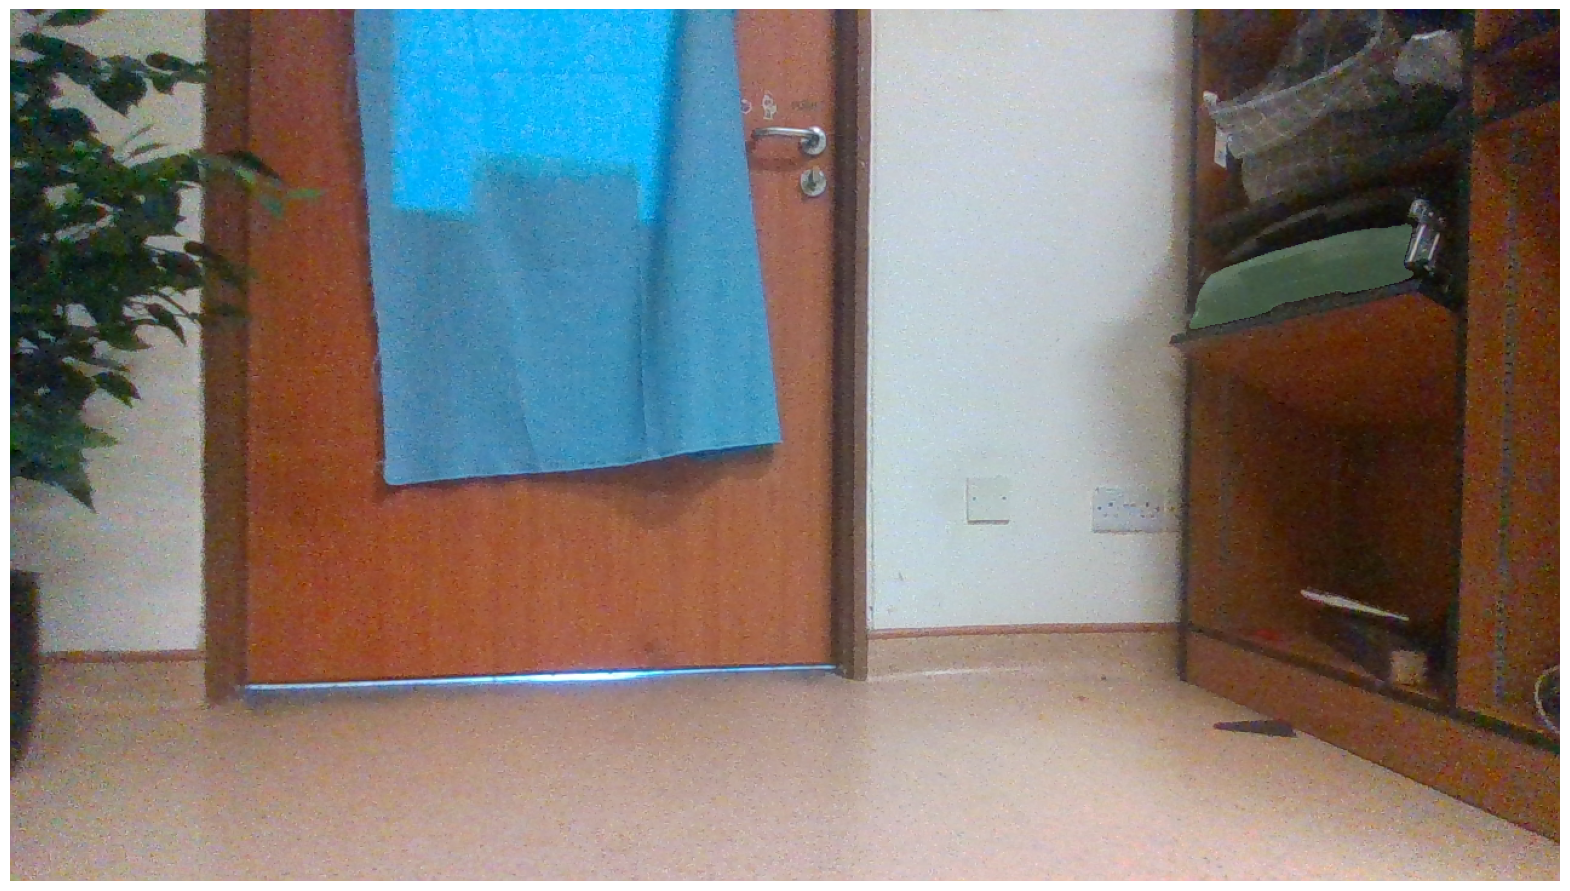

In [166]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

In [155]:
import numpy as np
from scipy.ndimage import measurements
point_list = []
# Assuming `binary_mask` is your binary mask array
for mask in masks:
    binary_mask = mask['segmentation']
    # Calculate the center of mass
    centroid = measurements.center_of_mass(binary_mask)

    centroid_int = (int(round(centroid[1])), int(round(centroid[0])))
    point_list.append(centroid_int)

   


/tmp/ipykernel_67411/1878674783.py:8: DeprecationWarning: Please use `center_of_mass` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  centroid = measurements.center_of_mass(binary_mask)


In [156]:
import copy
def point_placer(image, point_list):
    image = copy.deepcopy(image)
    is_pil = not isinstance(image, np.ndarray)
    if is_pil:
        image = np.asarray(image)
    height, width, _ = image.shape
    
    # Load a larger font
    font_scale = 0.5  # Adjust this value as needed
    font_thickness = 1  # Adjust this value as needed
    font = cv2.FONT_HERSHEY_TRIPLEX
    cnt=0
    # Calculate coordinates for grid points
    for x,y in point_list:
        text=str(cnt)
        cnt+=1
        (text_width, text_height), baseline = cv2.getTextSize(
                text,
                font,
                font_scale,
                2  # thickness
            )

        # Draw a solid black circle
        radius = max(text_width, text_height) //2  # Add some padding
        cv2.circle(image, (x, y), radius, (0, 0, 0), -1)
            
        # Calculate text size and position to center it
        text_size = cv2.getTextSize(text, font, font_scale, font_thickness)[0]
        text_x = x - text_size[0] // 2
        text_y = y + text_size[1] // 2
            
        # Draw the number in white
        cv2.putText(image, text, (text_x, text_y), font, font_scale, (255, 255, 255), font_thickness)
    if is_pil:
        image = Image.fromarray(image)
    
    
    return image

In [157]:
labeled_image = point_placer(image, point_list)

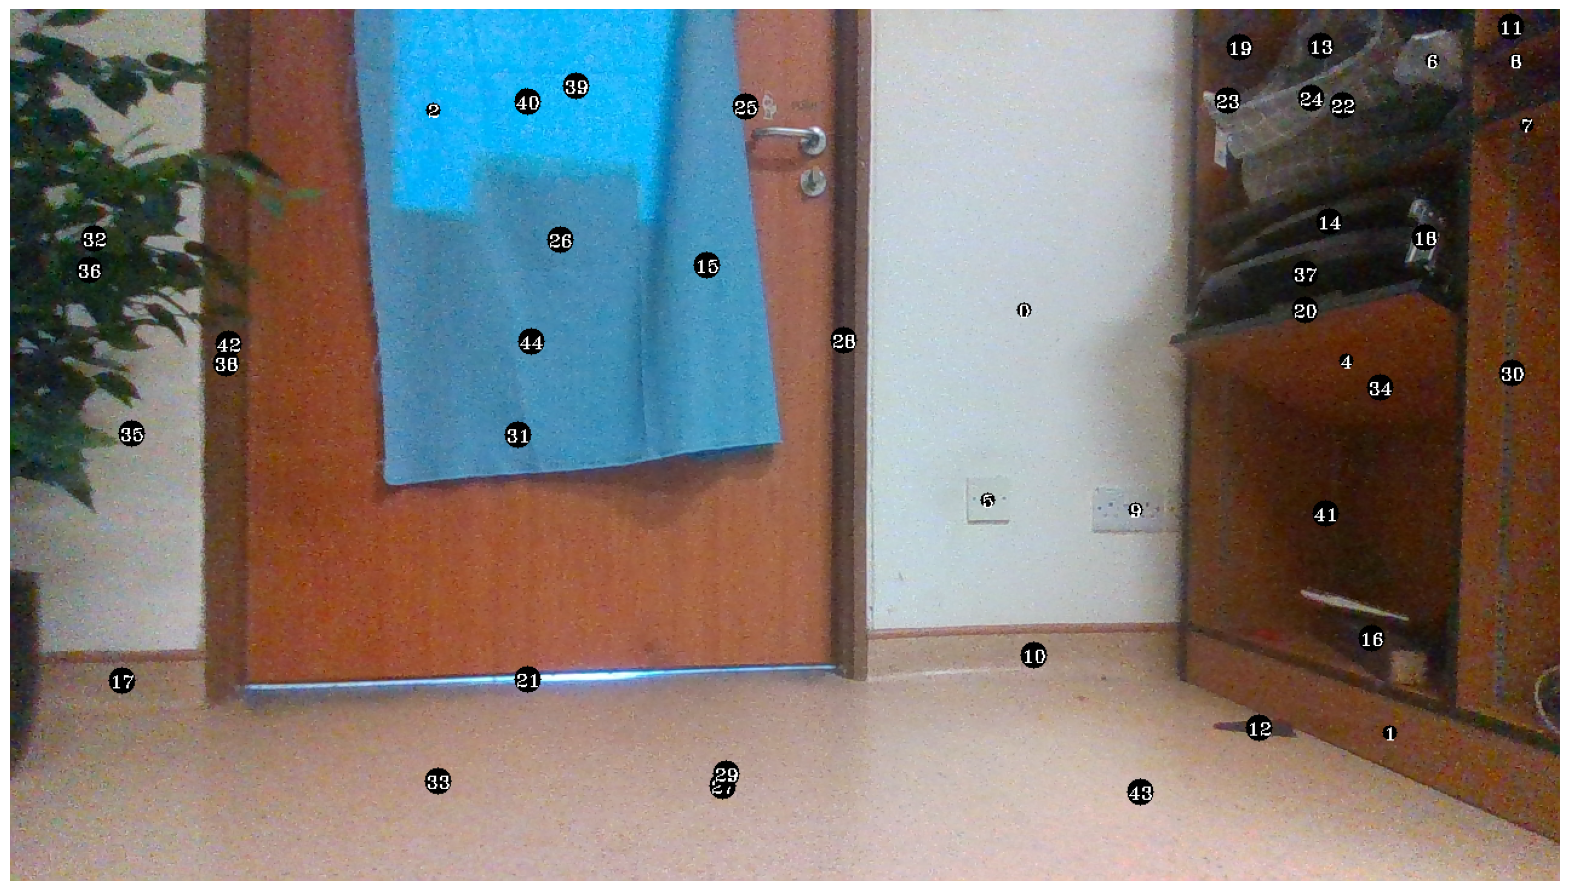

In [158]:
plt.figure(figsize=(20,20))
plt.imshow(labeled_image)
plt.axis('off')
plt.show() 